# Reading in Low fidelity (elevation and Temperature) and high fidelity data (surface temperature, elevation)

In [7]:
import xarray as xr
import iris
import numpy as np 
import pylab as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import os
import netCDF4 as nc


# In[13]:



### Regional gridded output from a Regional Climate Model (RCM)
hi_t2   = xr.open_dataset('data/hifid_t2m_monthly.nc')
hi_lats = hi_t2['latitude'].values
hi_lons = hi_t2['longitude'].values 

### Global gridded reanalysis (data assimilated) used to update/force the 
### lateral boundaries of the RCM
lo_t2  = xr.open_dataset('data/lofid_t2m_monthly.nc')
lo_u10 = xr.open_dataset('data/lofid_u10_monthly.nc')
lo_v10 = xr.open_dataset('data/lofid_v10_monthly.nc')

### work with numpy arrays
hi_t2_arr  = hi_t2['t2m'].values
lo_t2_arr  = lo_t2['t2m'].values 
lo_u10_arr = lo_u10['u10'].values
lo_v10_arr = lo_v10['v10'].values
time_dim   = lo_t2['time'].values 


##low fidelity lat and lon 
lo_lats = lo_t2['latitude'].values
lo_lons = lo_t2['longitude'].values

# high fidelity elevation data 
hi_elev = xr.open_dataset('data/hifid_hgt.nc')['hgt'].values
print(hi_elev.shape)
lo_t2_arr.shape
test = xr.open_dataset('data/hifid_hgt.nc')
hi_t2_arr.shape[0]*0.5

(93, 87)


234.0

# Make a plot of the high fidelity data

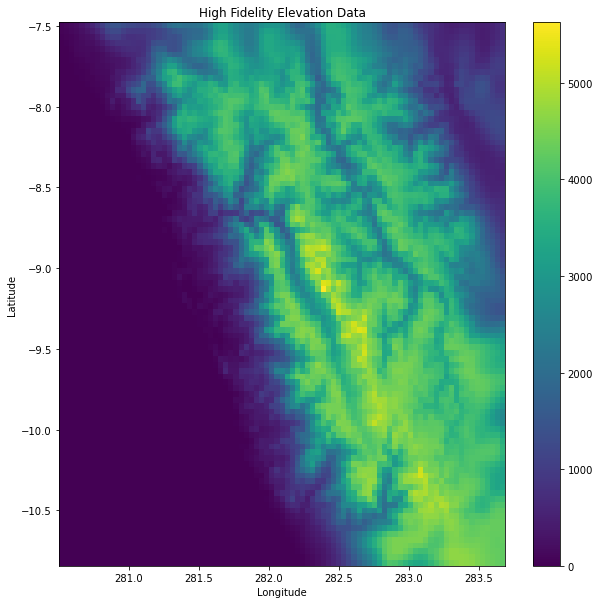

In [8]:
"""make plot of high fidelity elevation data using pcolormesh hi_lats and hi_lons"""    

plt.figure(figsize=(10,10))
plt.pcolormesh(hi_lons, hi_lats, hi_elev)
plt.colorbar()
plt.title('High Fidelity Elevation Data')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


# Define Neural Network trained with the high fidelity temperature and elevation data, and use the low fidelity temperature data to predict the low fidelity elevation

In [9]:
# In[14]:


def train_temp_model(temp_data, elevation_data, temp_data_lowres):
    # Convert data to float32
    temp_data = temp_data.astype(np.float32)
    elevation_data = elevation_data.astype(np.float32)

    # Define the model
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(temp_data.shape[1],)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(elevation_data.shape[1]))
    

    # Compile the model
    #model.compile(optimizer='adam', loss='mean_squared_error')
    model.compile(optimizer='adam', loss='mean_squared_error')
    # Train the model
    model.fit(temp_data, elevation_data, epochs=100, batch_size=32, verbose = False) # verbose = 0 showing no training progress

    # Pad the low-resolution temperature data with zeros
    padded_temp_data = np.zeros(temp_data.shape)
    padded_temp_data[:temp_data_lowres.shape[0],:temp_data_lowres.shape[1]] = temp_data_lowres
    
    # Predict elevation using the padded low-resolution temperature data
    elev_pred = model.predict(padded_temp_data)

    # Slice the elevation prediction values to the correct shape
    elev_pred_lowres = elev_pred[:temp_data_lowres.shape[0],:temp_data_lowres.shape[1]]
    
    return elev_pred_lowres
    
    
    

temp = np.array([]) # this is an array that will store

new_hi_t2_arr = hi_t2_arr.copy()
hi_t2_arr = hi_t2_arr[:5,:,:]  # this is to test over a smaller set
# these for loops are to generate temp array that will store the low fidelity elevation elevation profile



for i in range(hi_t2_arr.shape[0]):
#for i in range(1):
    pred = train_temp_model(hi_t2_arr[i,:,:], hi_elev, lo_t2_arr[i,:,:])
    pred = pred[np.newaxis,:,:] # add a new axis
    if i ==0:
        temp = pred.copy()
    else:
        temp = np.concatenate([temp,pred], axis = 0)
    print(f'value os i is {i} and max val = {hi_t2_arr.shape[0]}')
lo_elev = temp
print(hi_t2_arr.shape)
print(lo_t2_arr.shape)
print(pred.shape)

#save_netcdf(temp)






value os i is 0 and max val = 5
value os i is 1 and max val = 5
value os i is 2 and max val = 5
value os i is 3 and max val = 5
value os i is 4 and max val = 5
(5, 93, 87)
(468, 54, 52)
(1, 54, 52)


# plotting the low elevation profile estimated for each time index

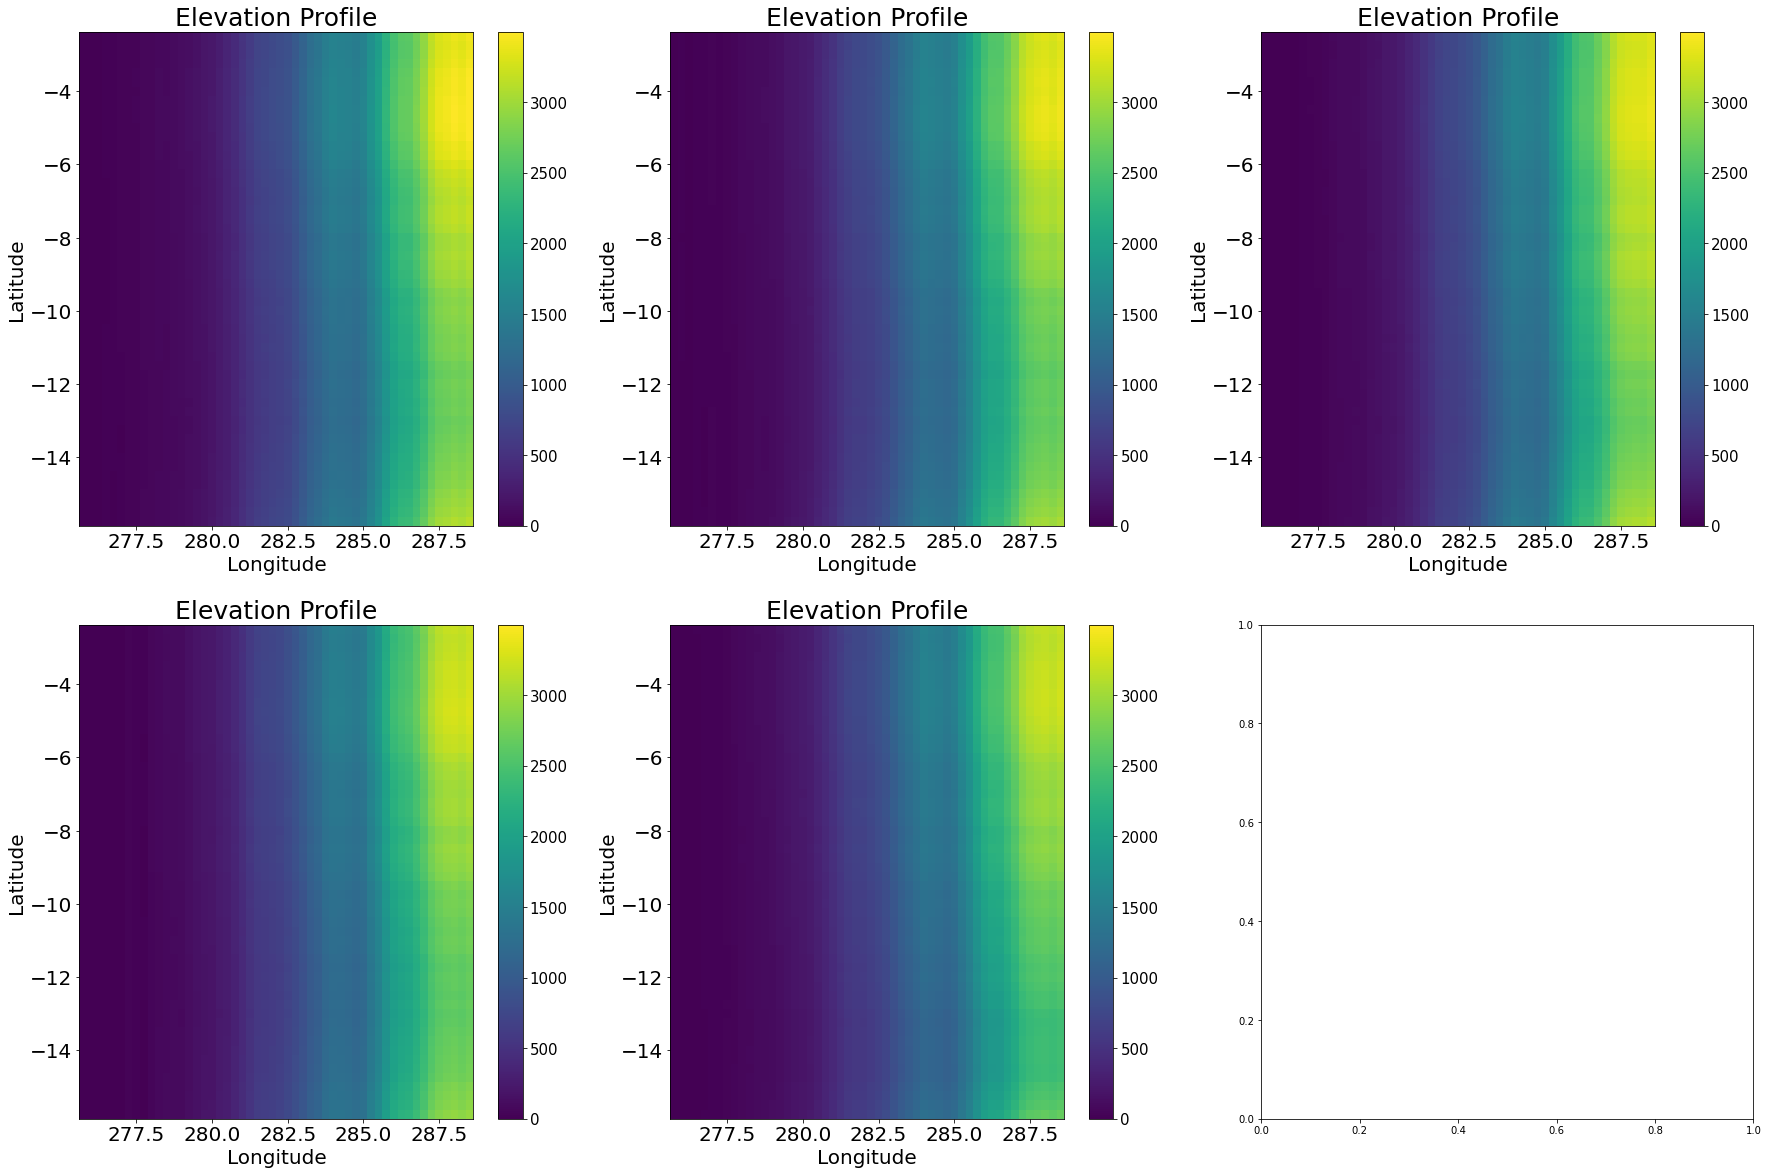

In [10]:
def plot_arr_subplots(lo_elev, min, max, step, nrows, ncols,str, error_arr):
    n_plots = lo_elev.shape[0]
    fig, axs = plt.subplots(nrows, ncols, figsize=(10*ncols,10*nrows))
    axs = axs.ravel()
    for i in range(n_plots):
        mappable = axs[i].pcolormesh(lo_lons, lo_lats, lo_elev[i,:,:], vmin=min, vmax=max)
        if len(error_arr)>0:
            str = f'NMBF = {error_arr[i]}'
        axs[i].set_title(str, fontsize=25)
        axs[i].set_xlabel('Longitude', fontsize=20)
        axs[i].set_ylabel('Latitude', fontsize=20)
        axs[i].tick_params(axis='both', which='major', labelsize=20)
        cbar = plt.colorbar(mappable, ax=axs[i], ticks=np.arange(min, max, step))
        cbar.ax.tick_params(labelsize=15)
    plt.show()

#plot_arr(lo_elev, 0, 3500, 500)

plot_arr_subplots(lo_elev, 0, 3500, 500, 2, 3,'Elevation Profile',[])

# Plotting the error and NMBF between each combination of the above plots

value of i =  0 value of j =  1
value of i =  0 value of j =  2
value of i =  0 value of j =  3
value of i =  0 value of j =  4
value of i =  1 value of j =  2
value of i =  1 value of j =  3
value of i =  1 value of j =  4
value of i =  2 value of j =  3
value of i =  2 value of j =  4
value of i =  3 value of j =  4


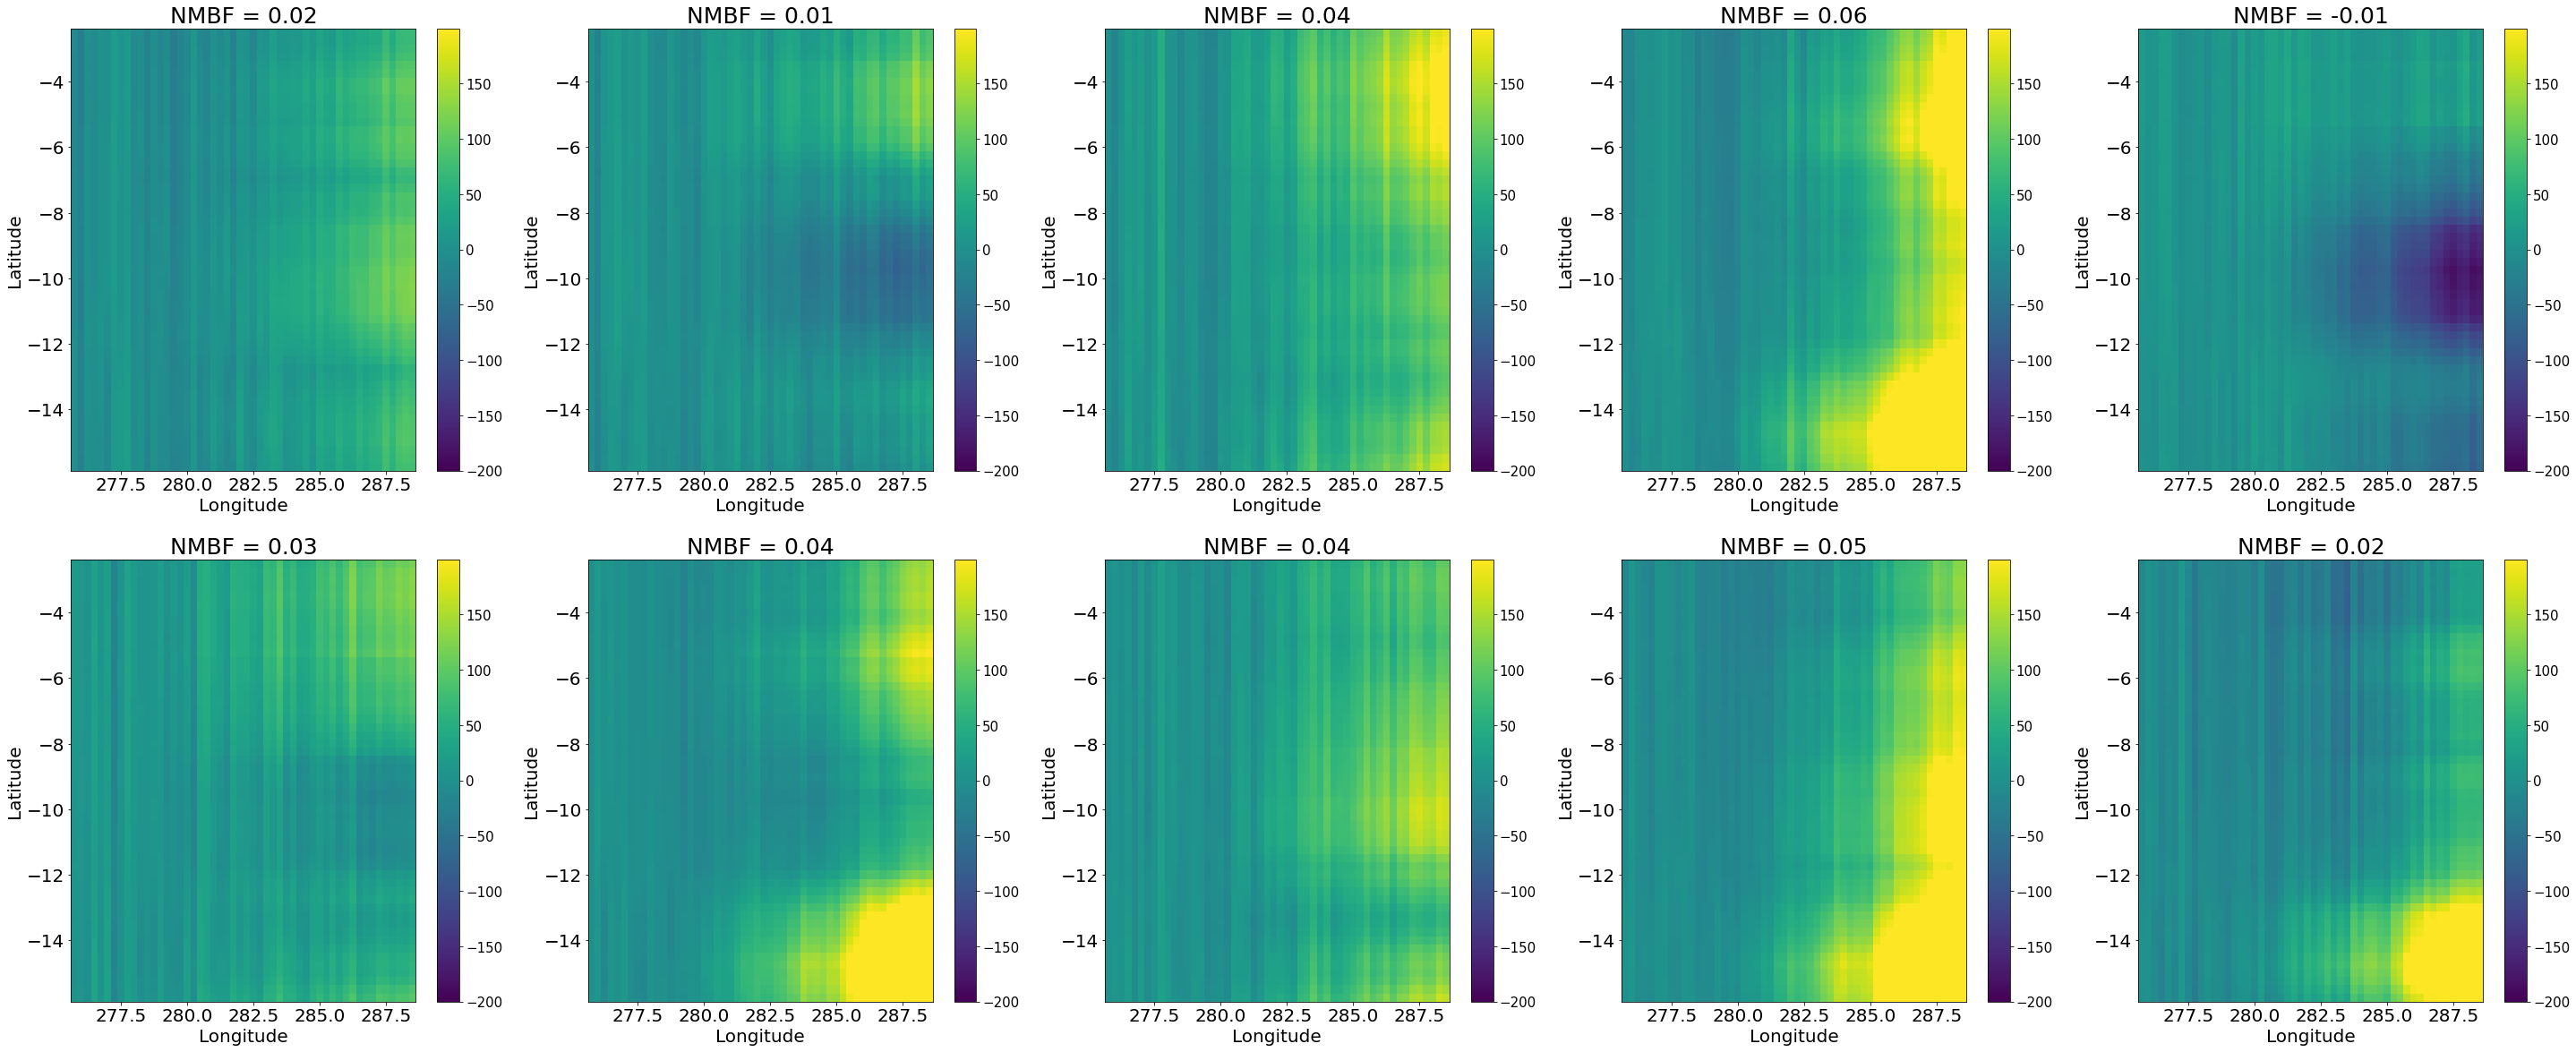

In [11]:
from itertools import combinations

# absolute value of difference
def diff1(arr1, arr2):
    return (arr1 - arr2)

# calculate normalized absolution mean bias factor
def calc_nambf(array1, array2):
    numerator = np.abs(array1 - array2).mean()
    denominator = 0.5 * (np.abs(array1).mean() + np.abs(array2).mean())
    nambf = numerator / denominator
    return nambf

# calculate normalised mean bias factor
def calc_nmbf(array1, array2):
    numerator = (array1 - array2).mean()
    denominator = np.abs(array1).mean()
    nmbf = numerator / denominator
    return round(nmbf,2)

error_arr = []
comb = combinations(range(lo_elev.shape[0]), 2)
#print(comb.shape)
nmbf_arr = np.array([])
counter = 0;
for i, j in comb:
    print('value of i = ', i, 'value of j = ', j)
    elev1 = lo_elev[i,:,:]
    elev2 = lo_elev[j,:,:]

    # call error estimation functio above 
    error1 = diff1(elev1,elev2)
    error2 = calc_nmbf(elev1,elev2)
    #print('shape of nmbf = ', error2)
    error1 = error1[np.newaxis,:,:] # add a new axis
    #error2 = error2[np.newaxis,:,:] # add a new axis
    
    if counter ==0:
        error_1st = error1.copy()
    else:
        error_1st = np.concatenate([error_1st,error1], axis = 0)
    
    counter += 1
    nmbf_arr = np.append(nmbf_arr,round(error2,2))
#plot_arr(error, -200,200, 50)

plot_arr_subplots(error_1st, -200, 200, 50, 2, 5,'Elev Diff',np.round(nmbf_arr,3))
#plot_arr_subplots(error, -200, 200, 50, 2, 5)
